In [47]:
import warnings
warnings.filterwarnings("ignore")

In [48]:
import pandas as pd 
import seaborn as sns 
import statistics
import numpy as np
import matplotlib.pyplot as plt

In [49]:
from ydata_profiling import ProfileReport

In [50]:
%matplotlib inline

In [51]:
modeldf2019 = pd.read_csv('mydata/MMSA2019_train.csv')
modeldf2021 = pd.read_csv('mydata/MMSA2021_train.csv')

In [52]:
#pd.set_option('display.max_columns', None)

In [53]:
pd.set_option('display.max_info_columns', 1000)
pd.set_option('display.max_info_rows', 1000000)

In [54]:
import io
buffer = io.StringIO()
modeldf2019.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140514 entries, 0 to 140513
Data columns (total 180 columns):
 #    Column      Non-Null Count   Dtype  
---   ------      --------------   -----  
 0    Unnamed: 0  140514 non-null  int64  
 1    DISPCODE    140514 non-null  int64  
 2    STATERE1    47593 non-null   float64
 3    CELPHONE    47593 non-null   float64
 4    LADULT1     47593 non-null   float64
 5    COLGSEX     11 non-null      float64
 6    LANDSEX     20189 non-null   float64
 7    RESPSLCT    24008 non-null   float64
 8    SAFETIME    92921 non-null   float64
 9    CADULT1     92921 non-null   float64
 10   CELLSEX     92917 non-null   float64
 11   HHADULT     92918 non-null   float64
 12   SEXVAR      140514 non-null  int64  
 13   GENHLTH     140501 non-null  float64
 14   PHYSHLTH    140503 non-null  float64
 15   MENTHLTH    140508 non-null  float64
 16   POORHLTH    77558 non-null   float64
 17   HLTHPLN1    140510 non-null  float64
 18   PERSDOC2    140511 non

In [55]:
buffer = io.StringIO()
modeldf2021.info(buf=buffer)
info_str = buffer.getvalue()
print(info_str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151861 entries, 0 to 151860
Data columns (total 152 columns):
 #    Column    Non-Null Count   Dtype  
---   ------    --------------   -----  
 0    DISPCODE  151861 non-null  float64
 1    STATERE1  37094 non-null   float64
 2    CELPHON1  37094 non-null   float64
 3    LADULT1   37094 non-null   float64
 4    COLGSEX   13 non-null      float64
 5    LANDSEX   15568 non-null   float64
 6    RESPSLCT  20603 non-null   float64
 7    SAFETIME  114767 non-null  float64
 8    CADULT1   114767 non-null  float64
 9    CELLSEX   114766 non-null  float64
 10   HHADULT   114766 non-null  float64
 11   SEXVAR    151861 non-null  float64
 12   GENHLTH   151860 non-null  float64
 13   PHYSHLTH  151859 non-null  float64
 14   MENTHLTH  151861 non-null  float64
 15   POORHLTH  81991 non-null   float64
 16   PRIMINSR  151860 non-null  float64
 17   PERSDOC3  151861 non-null  float64
 18   MEDCOST1  151860 non-null  float64
 19   CHECKUP1  151861 non-

In [56]:
#Fill missing values of extra columns with current categorical values to keep ratio randomnly 

In [57]:
#Handle missing data 

### Merging 2019 and 2021 BRFSS Dataframes Using Columns of Interest

In [58]:
#Any variable with value counts below 14 with be turned to a categorical nominal datatype:
# Convert 'col1' from float to categorical
for col in modeldf2019.columns:
    if len(modeldf2019[col].value_counts()) < 15:
        modeldf2019[col] = modeldf2019[col].astype('category')
        
for col in modeldf2021.columns:
    if len(modeldf2021[col].value_counts()) < 15:
        modeldf2021[col] = modeldf2021[col].astype('category')
               

In [59]:
##Extract state from MMSANAME
def get_state(col):
    return col.split(',')[1]

modeldf2019['STATE'] = modeldf2019['MMSANAME'].apply(get_state)
modeldf2021['STATE'] = modeldf2021['MMSANAME'].apply(get_state)

In [60]:
columns = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1', '_HLTHPLN','PRIMINSR', '_RACE', 'MEDCOST1', 'MARITAL', '_EDUCAG', 
                'RENTHOM1', 'EMPLOY1', 'CHILDREN', '_INCOMG1', '_TOTINDA', 'CHCOCNCR', 'SMOKE100', 
                'SMOKDAY2', 'USENOW3','_SMOKER3', '_RFSMOK3','_RFBING5', 'DIABETE4','EXERANY2', 
                'CHCOCNCR', '_MICHD', '_RFHYPE6', '_RFCHOL3', 'ADDEPEV3', 'DECIDE','_AGE65YR', 
                'WTKG3', '_BMI5', '_BMI5CAT', '_SEX','STATE','SEQNO','_RFHLTH']
len(columns)

42

In [61]:
#RENAME COLUMNS in 2019 dataset to match 2021:
modeldf2019.rename(columns={'_INCOMG':'_INCOMG1','_RFHYPE5':'_RFHYPE6','HLTHPLN1': 'PRIMINSR','MEDCOST':'MEDCOST1',
                  '_RFCHOL2':'_RFCHOL3'},inplace=True)

In [62]:
#Create a _HLTHPLN from PRIMINSR IN 2019 df (- '_HLTHPLN' - Categorical variable for healthcare plan )

modeldf2019['_HLTHPLN'] = modeldf2019['PRIMINSR'].apply(lambda x: 1 if x in [1,2,3,4,5,6,7,8,9] 
                                                        else 2 if x == 88 else 'NA')

modeldf2019['_TOTINDA'] = modeldf2019['_TOTINDA'].astype(float)

#Create a DROCDY3_ from ALCDAY5 by dividing the ALCDAY5 variable by 7 days per week or 30 days per month
def compute_drocdy3_(x):
    # Handle NaN values
    if pd.isna(x):
        return np.nan
    
    x_int = int(str(x).split(".")[0])
    
    if x_int == 888:
        return 0.0
    elif x_int // 100 == 1:
        return (x_int % 100) / 7.0
    elif x_int // 100 == 2:
        return (x_int % 100) / 30.0
    elif x_int in [777, 999]:
        return np.nan
    else:
        return float(x_int)

modeldf2019['DROCDY3_'] = modeldf2019['ALCDAY5'].apply(compute_drocdy3_)
modeldf2021['DROCDY3_'] = modeldf2021['ALCDAY5'].apply(compute_drocdy3_)

In [63]:
# Get common columns
common_columns = modeldf2019.columns.intersection(modeldf2021.columns)

# Concatenate DataFrames based on common columns
brfss_df = pd.concat([modeldf2019[common_columns], modeldf2021[common_columns]],ignore_index=True )


In [64]:
#Convert appropriate columns into categories
# List of columns to convert
columns_list = ['_AGE65YR', '_INCOMG1', '_TOTINDA', '_HLTHPLN', '_RFBING5', 
                'PRIMINSR', '_EDUCAG', '_SMOKER3','_RFSMOK3','_SEX', '_RFHYPE6','PHYSHLTH',
                '_RFHLTH','MENTHLTH','_AGEG5YR','_ASTHMS1','_HISPANC','ALCDAY5']

# Convert each column to category data type in place
for col in columns_list:
    brfss_df[col] = brfss_df[col].astype('category')

#convert height to height in meters
def calculate_htinm(height3):
    if 300 <= height3 <= 311:
        htinm = ((height3 - 300) + 36)*0.0254
    elif 400 <= height3 <= 411:
        htinm = ((height3 - 400) + 48)*0.0254
    elif 500 <= height3 <= 511:
        htinm = ((height3 - 500) + 60)*0.0254
    elif 600 <= height3 <= 611:
        htinm = ((height3 - 600) + 72)*0.0254
    elif 700 <= height3 <= 711:
        htinm = ((height3 - 700) + 84)*0.0254
    else:
        htinm = None  # Handle cases that don't match any condition
    
    return htinm

brfss_df['HEIGHT3'] = brfss_df['HEIGHT3'].apply(calculate_htinm)


In [65]:
brfss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292375 entries, 0 to 292374
Data columns (total 136 columns):
 #    Column    Non-Null Count   Dtype   
---   ------    --------------   -----   
 0    DISPCODE  292375 non-null  float64 
 1    STATERE1  84687 non-null   category
 2    LADULT1   84687 non-null   float64 
 3    COLGSEX   24 non-null      category
 4    LANDSEX   35757 non-null   float64 
 5    RESPSLCT  44611 non-null   float64 
 6    SAFETIME  207688 non-null  category
 7    CADULT1   207688 non-null  category
 8    CELLSEX   207683 non-null  float64 
 9    HHADULT   207684 non-null  float64 
 10   SEXVAR    292375 non-null  float64 
 11   GENHLTH   292361 non-null  category
 12   PHYSHLTH  292362 non-null  category
 13   MENTHLTH  292369 non-null  category
 14   POORHLTH  159549 non-null  float64 
 15   PRIMINSR  292370 non-null  category
 16   MEDCOST1  292371 non-null  category
 17   CHECKUP1  292370 non-null  category
 18   BPMEDS    110772 non-null  category
 19   

In [66]:
#Lets make a copy of the merged dataframe
processed_features_df = brfss_df.copy()

#Place decimal place in fruit and vegetable columns (as it was implied)
def convert_decimal(x):
    if pd.isna(x):
        return np.nan
    else:
        return x/100
    
cols = ['FRNCHDA_','POTADA1_', 'FRUTDA2_', 'FTJUDA2_', 'VEGEDA2_', 'GRENDA1_', 
                '_FRUTSU1', '_VEGESU1','WTKG3','_BMI5']

#Convert features to appropriate values by placing the decimal place 
for col in cols:
    processed_features_df[col] = processed_features_df[col].apply(convert_decimal)
    
#Convert STATE column to US state
from States import states
processed_features_df['STATE'] = processed_features_df['STATE'].apply(lambda x: states[(x[-2:])] 
                                                                      if (x[-2:]) in states else x)

In [67]:
#list(processed_features_df['STATE'].unique())

### Generate EDA Report with Original Dataset

In [68]:
#profile = ProfileReport(modeldf2019)
#profile.to_file(output_file="mydata/EDA_Report_2019.html")

#profile = ProfileReport(modeldf2021)
#profile.to_file(output_file="mydata/EDA_Report_2021.html")

### Data Cleaning Handle Missing data

In [69]:
pd.reset_option('display.max_rows',None)

In [70]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.to_string())

           Total   Percent
COLGSEX   292351  0.999918
NUMPHON3  269608  0.922131
CAGEG     257854  0.881929
LANDSEX   256618  0.877702
DIABAGE3  255624  0.874302
ASTHNOW   250739  0.857594
RESPSLCT  247764  0.847419
PREGNANT  236303  0.808219
NUMHHOL3  208063  0.711631
STATERE1  207688  0.710348
LADULT1   207688  0.710348
ARTHDIS2  202351  0.692094
LMTJOIN3  202349  0.692087
ARTHEDU   202348  0.692084
JOINPAI2  202348  0.692084
ARTHEXER  202347  0.692080
HIVTSTD3  198554  0.679107
_FLSHOT7  189818  0.649228
_PNEUMO3  189818  0.649228
SMOKDAY2  184042  0.629472
BPMEDS    181603  0.621130
FLSHTMY3  152870  0.522856
MAXDRNKS  146416  0.500782
DRNK3GE5  146119  0.499766
AVEDRNK3  145632  0.498100
POORHLTH  132826  0.454300
CELLSEX    84692  0.289669
HHADULT    84691  0.289666
SAFETIME   84687  0.289652
CADULT1    84687  0.289652
_VEGESU1   40157  0.137348
_RFCHOL3   36044  0.123280
_FRUTSU1   34055  0.116477
VEGEDA2_   33123  0.113289
POTADA1_   32643  0.111648
_BMI5CAT   30513  0.104363
_

In [71]:
#Drop columns with more that 45% missing values 
col_more45 = list(missing_data.index[missing_data['Percent'] > 0.45])
col_more45
processed_features_df.drop(columns=col_more45,inplace=True)

#Drop columns that are of very low variance and have high unque vales and may be of no importance to ones health

processed_features_df.drop(columns=['SAFETIME','CELLSEX','DISPCODE','_MMSA','_MMSAWT'],inplace=True)
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292375 entries, 0 to 292374
Data columns (total 105 columns):
 #    Column    Non-Null Count   Dtype   
---   ------    --------------   -----   
 0    CADULT1   207688 non-null  category
 1    HHADULT   207684 non-null  float64 
 2    SEXVAR    292375 non-null  float64 
 3    GENHLTH   292361 non-null  category
 4    PHYSHLTH  292362 non-null  category
 5    MENTHLTH  292369 non-null  category
 6    PRIMINSR  292370 non-null  category
 7    MEDCOST1  292371 non-null  category
 8    CHECKUP1  292370 non-null  category
 9    CVDINFR4  292371 non-null  category
 10   CVDCRHD4  292371 non-null  category
 11   CVDSTRK3  292370 non-null  category
 12   ASTHMA3   292371 non-null  category
 13   CHCSCNCR  292371 non-null  category
 14   CHCOCNCR  292371 non-null  category
 15   ADDEPEV3  292370 non-null  category
 16   CHCKDNY2  292371 non-null  category
 17   DIABETE4  292371 non-null  category
 18   MARITAL   292353 non-null  category
 19   

##### Vegetable and fruit columns calculated from other veg_fruit columns (So we will keep only these ones)
     'FRNCHDA_'- french fry intake in time per day 2
     'POTADA1_' - computed potatoe servings per day 
     'FRUTDA2_',- number of fruits consunmed per day 
     'FTJUDA2_'- computed fruit juice intake in times per day 
     'VEGEDA2_', - COMPUTED NUMBER OF OTHER VEGIES eaten per day - not lettuce or potatoe 
     'GRENDA1_'- Number of dark green vegetables per day Times per day  
     'FRUTSU1', Number of Fruits consumed per day 
     'VEGESU1', Number of Vegetables consumed per day 


In [72]:
#Drop redundant Columns and irreleveant columns
processed_features_df.drop(columns=['_AGE80','_AGE65YR','_AGE_G','SEXVAR',
                                    'WEIGHT2','_CASTHM1','_LTASTH1','PRIMINSR','EXERANY2','CHILDREN','EDUCA',
                                    'ASTHMA3','SMOKE100','CPDEMO1B','_STSTR','CVDINFR4','CVDCRHD4','_RACEG21'
                                   ,'_RACEGR3','_PRACE1','_MRACE1','_IMPSEX','CADULT1','GENHLTH',
                                    'HHADULT','_RFBMI5','VEGETAB2','POTATOE1','FRENCHF1',
                                    'FVGREEN1','FRUITJU2','FRUIT2','HIVTST7'],inplace=True)

<Axes: >

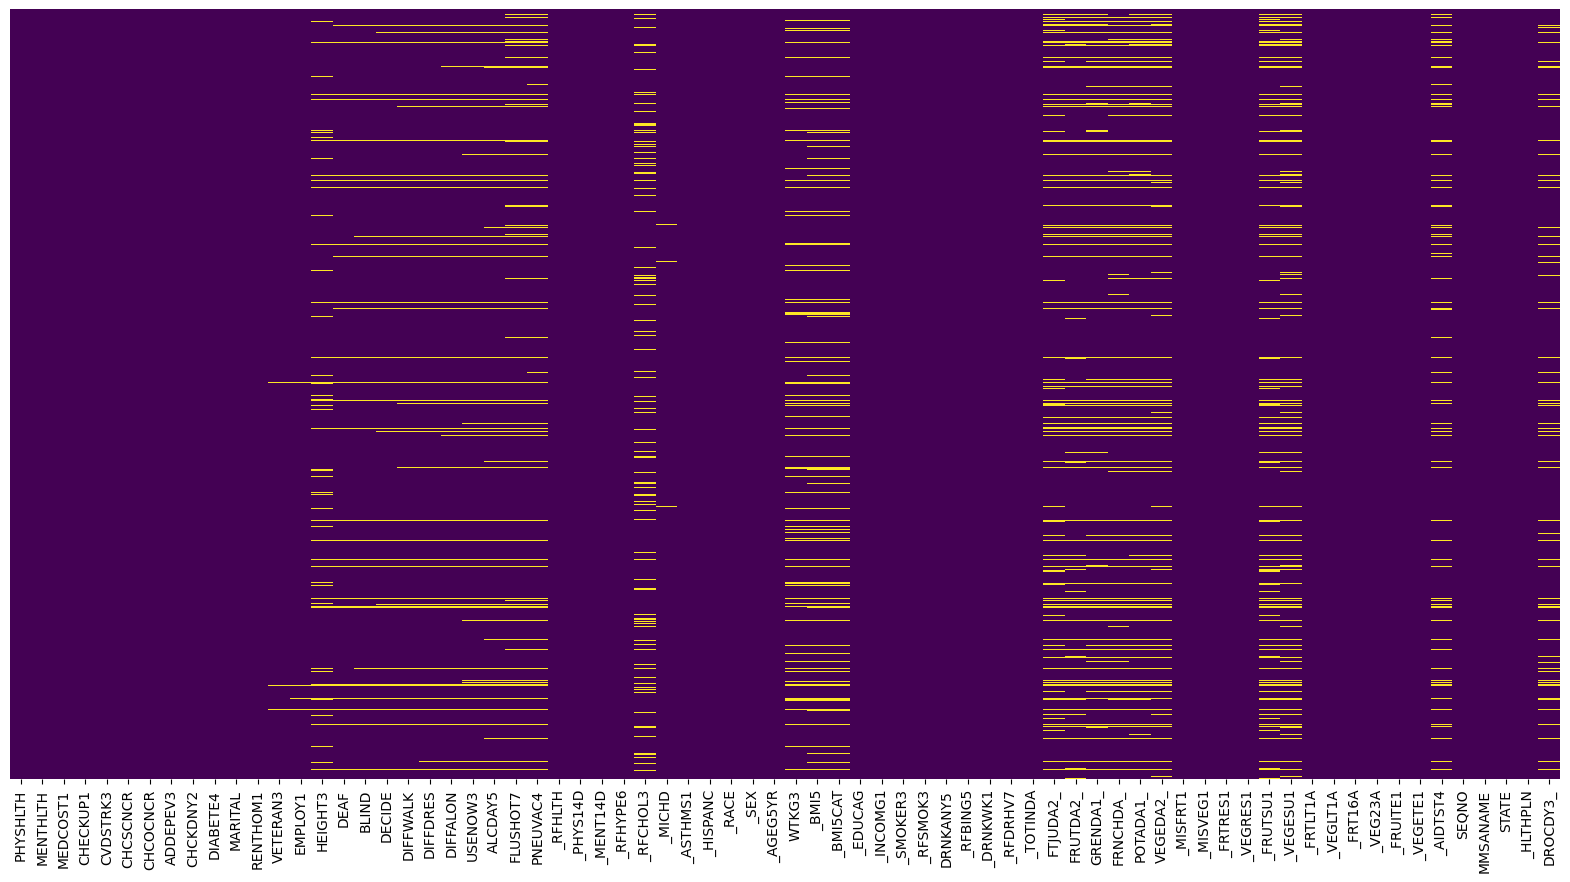

In [73]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [74]:
#Drop the rows where columns have less than 5% missing values 
#list of columns with less than 5% missing data 

#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

col_less5miss = list(missing_data.index[missing_data['Percent'] < 0.05])
processed_features_df.dropna(subset=col_less5miss,inplace=True)

In [75]:
print(missing_data.to_string())

          Total   Percent
_VEGESU1  40157  0.137348
_RFCHOL3  36044  0.123280
_FRUTSU1  34055  0.116477
VEGEDA2_  33123  0.113289
POTADA1_  32643  0.111648
_BMI5CAT  30513  0.104363
_BMI5     30513  0.104363
FRNCHDA_  30277  0.103555
FTJUDA2_  29985  0.102557
GRENDA1_  29957  0.102461
FRUTDA2_  29670  0.101479
WTKG3     25698  0.087894
_AIDTST4  25539  0.087350
PNEUVAC4  24264  0.082989
FLUSHOT7  23345  0.079846
DROCDY3_  19682  0.067318
HEIGHT3   18198  0.062242
ALCDAY5   15891  0.054351
USENOW3   14298  0.048903
DIFFALON  12861  0.043988
DIFFDRES  12203  0.041737
DIFFWALK  11702  0.040024
DECIDE    10982  0.037561
BLIND     10310  0.035263
DEAF       9556  0.032684
_MICHD     2890  0.009885
EMPLOY1    2394  0.008188
VETERAN3   1125  0.003848
MARITAL      22  0.000075
RENTHOM1     14  0.000048
PHYSHLTH     13  0.000044
MENTHLTH      6  0.000021
ADDEPEV3      5  0.000017
CVDSTRK3      5  0.000017
CHECKUP1      5  0.000017
MEDCOST1      4  0.000014
CHCOCNCR      4  0.000014
CHCKDNY2    

In [76]:
#replace the missing values in height with the mean for males and mean for females as it is normally distributed 

# Calculate mean height values for men and women separately
mean_height_men = processed_features_df[processed_features_df['_SEX'] == 1]['HEIGHT3'].mean()
mean_height_women = processed_features_df[processed_features_df['_SEX'] == 2]['HEIGHT3'].mean()

# Replace missing values with the corresponding mean height value
processed_features_df.loc[(processed_features_df['_SEX'] == 1) & (processed_features_df['HEIGHT3'].isnull()), 'HEIGHT3'] = mean_height_men
processed_features_df.loc[(processed_features_df['_SEX'] == 2) & (processed_features_df['HEIGHT3'].isnull()), 'HEIGHT3'] = mean_height_women

In [77]:
#replace the missing values in weight with the mean for males and mean for females as it is normally distributed 
#'WTKG3' - Weight in KG

# Calculate mean weight values for men and women separately
mean_height_men = processed_features_df[processed_features_df['_SEX'] == 1]['WTKG3'].mean()
mean_height_women = processed_features_df[processed_features_df['_SEX'] == 2]['WTKG3'].mean()

# Replace missing values with the corresponding mean weight value
processed_features_df.loc[(processed_features_df['_SEX'] == 1) & (processed_features_df['WTKG3'].isnull()), 'WTKG3'] = mean_height_men
processed_features_df.loc[(processed_features_df['_SEX'] == 2) & (processed_features_df['WTKG3'].isnull()), 'WTKG3'] = mean_height_women

In [78]:
#Fill in the missing _BMI5 values with the calculated value from weight and height 

# Replace missing values with the Calculated BMI value
processed_features_df['_BMI5'].fillna(processed_features_df['WTKG3'] / processed_features_df['HEIGHT3']**2, inplace=True)

#fill in the missing _BMICAT5 categories with the alotted categories based on _BMI5
def categorize_bmi(_BMI5):
    if 0.00 <= _BMI5 < 18.50:
        return 1
    elif 18.50 <= _BMI5 < 25.00:
        return 2
    elif 25.00 <= _BMI5 < 30.00:
        return 3
    elif _BMI5 >= 30.00:
        return 4
    else:
        return None  # Handle other possible cases (e.g. negative BMI or None)

processed_features_df['_BMI5CAT']= processed_features_df['_BMI5'].apply(categorize_bmi)
processed_features_df['_BMI5CAT'] = processed_features_df['_BMI5CAT'].astype('category')
processed_features_df.drop(columns='_BMI5',inplace=True)

In [79]:
#Drop rows where these columns are null
column_names = [
    "MENTHLTH",
    "ADDEPEV3",
    "CHECKUP1",
    "CVDSTRK3",
    "DIABETE4",
    "_HLTHPLN",
    "MEDCOST1",
    "CHCSCNCR",
    "CHCOCNCR",
    "CHCKDNY2",
    "_RACE"
]
processed_features_df.dropna(subset=column_names,inplace=True)

In [80]:
#check missing values in train dataset
total = processed_features_df.isnull().sum().sort_values(ascending=False)
percent = (processed_features_df.isnull().sum()/processed_features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#print(missing_data.to_string())

In [81]:
#Replace missing fruit and vegetable column values with the median value for each race & Age category assuming that
#different races and ages tend to have different diets
fruit_veg_columns = [
    '_VEGESU1',
    '_FRUTSU1',
    'VEGEDA2_',
    'POTADA1_',
    'FRNCHDA_',
    'FTJUDA2_',
    'GRENDA1_',
    'FRUTDA2_']

for col in fruit_veg_columns:
    medians = processed_features_df.groupby(['_RACE', '_AGEG5YR'])[col].transform('median')
    processed_features_df[col].fillna(medians, inplace=True)


In [82]:
#The missing values in _RFCHOL3 are filled in a way that preserves the ratio of its subcategories. 
#This can be useful if you believe that the observed distribution is representative and want 
#the filled values to reflect that same distribution.

# Find distribution of non-missing values
value_counts = processed_features_df['_RFCHOL3'].value_counts(normalize=True)

# Fill missing values by sampling based on this distribution
missing_count = processed_features_df['_RFCHOL3'].isna().sum()
if missing_count > 0:
    imputed_values = np.random.choice(value_counts.index, 
                                      p=value_counts.values, 
                                      size=missing_count)
    processed_features_df.loc[processed_features_df['_RFCHOL3'].isna(), '_RFCHOL3'] = imputed_values

In [83]:
#Drop all rows with any NA values 
processed_features_df.dropna(inplace=True)
#processed_features_df.info()

<Axes: >

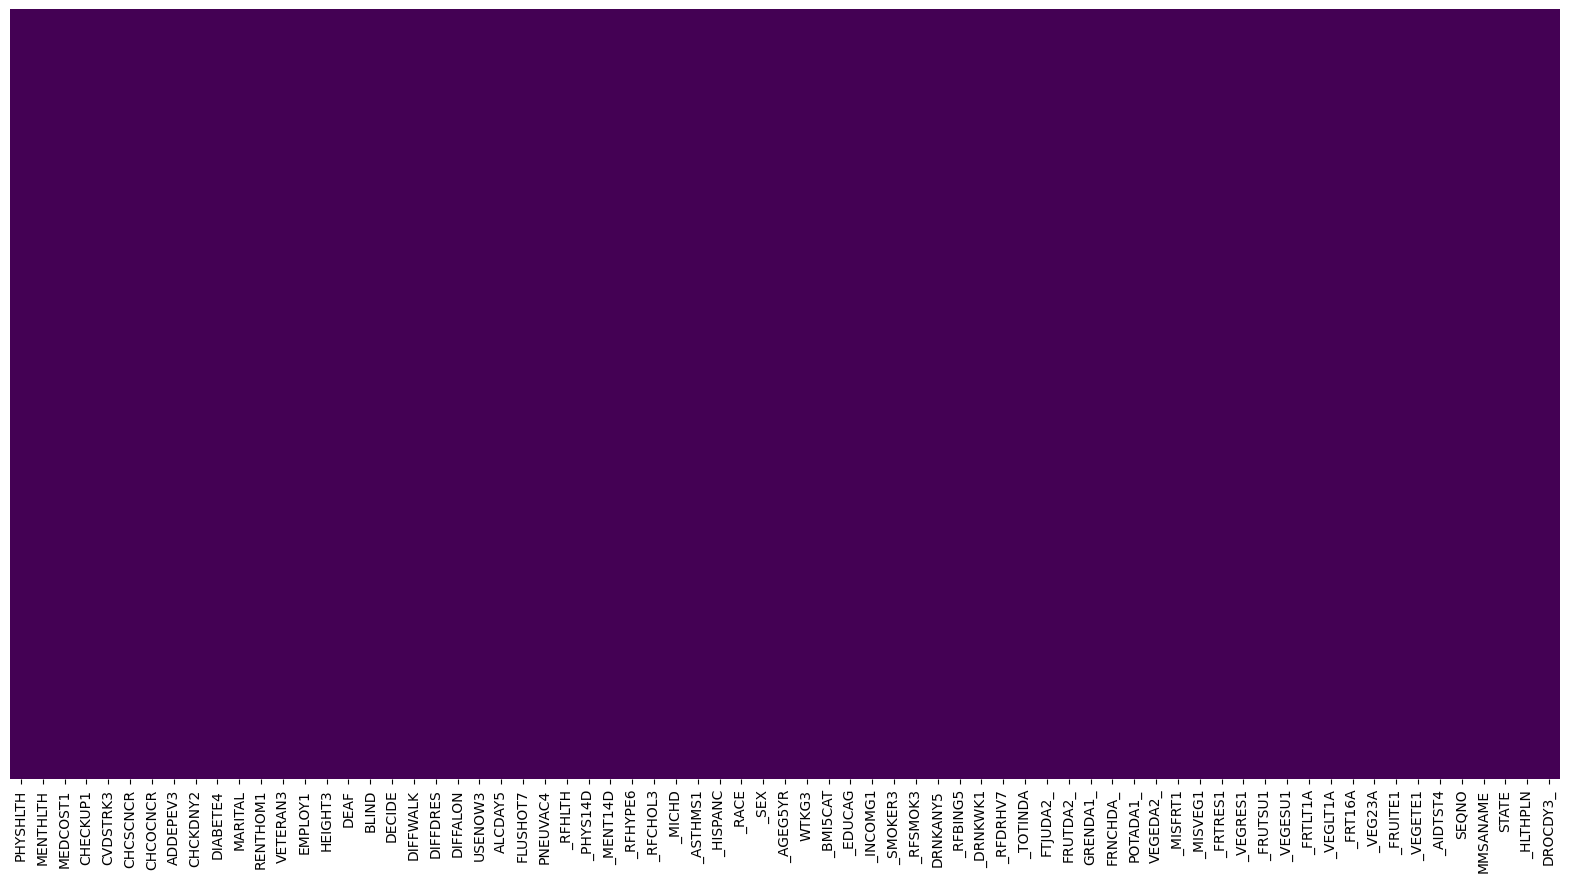

In [84]:
#vizualize misisng values using a heatmap
plt.figure(figsize=(20,10))
sns.heatmap(processed_features_df.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [85]:
#Lets Generate A profile report of the cleaned data
#profile = ProfileReport(processed_features_df,minimal=True,explorative=True,dark_mode=True)
#profile.to_file(output_file="mydata/EDA_Report_Cleaned.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [86]:
processed_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260800 entries, 0 to 292374
Data columns (total 71 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   PHYSHLTH  260800 non-null  category
 1   MENTHLTH  260800 non-null  category
 2   MEDCOST1  260800 non-null  category
 3   CHECKUP1  260800 non-null  category
 4   CVDSTRK3  260800 non-null  category
 5   CHCSCNCR  260800 non-null  category
 6   CHCOCNCR  260800 non-null  category
 7   ADDEPEV3  260800 non-null  category
 8   CHCKDNY2  260800 non-null  category
 9   DIABETE4  260800 non-null  category
 10  MARITAL   260800 non-null  category
 11  RENTHOM1  260800 non-null  category
 12  VETERAN3  260800 non-null  category
 13  EMPLOY1   260800 non-null  category
 14  HEIGHT3   260800 non-null  float64 
 15  DEAF      260800 non-null  category
 16  BLIND     260800 non-null  category
 17  DECIDE    260800 non-null  category
 18  DIFFWALK  260800 non-null  category
 19  DIFFDRES  260800 non-nu

In [87]:
num_cols = processed_features_df.select_dtypes(include='float').columns

<Axes: >

<Figure size 1200x800 with 0 Axes>

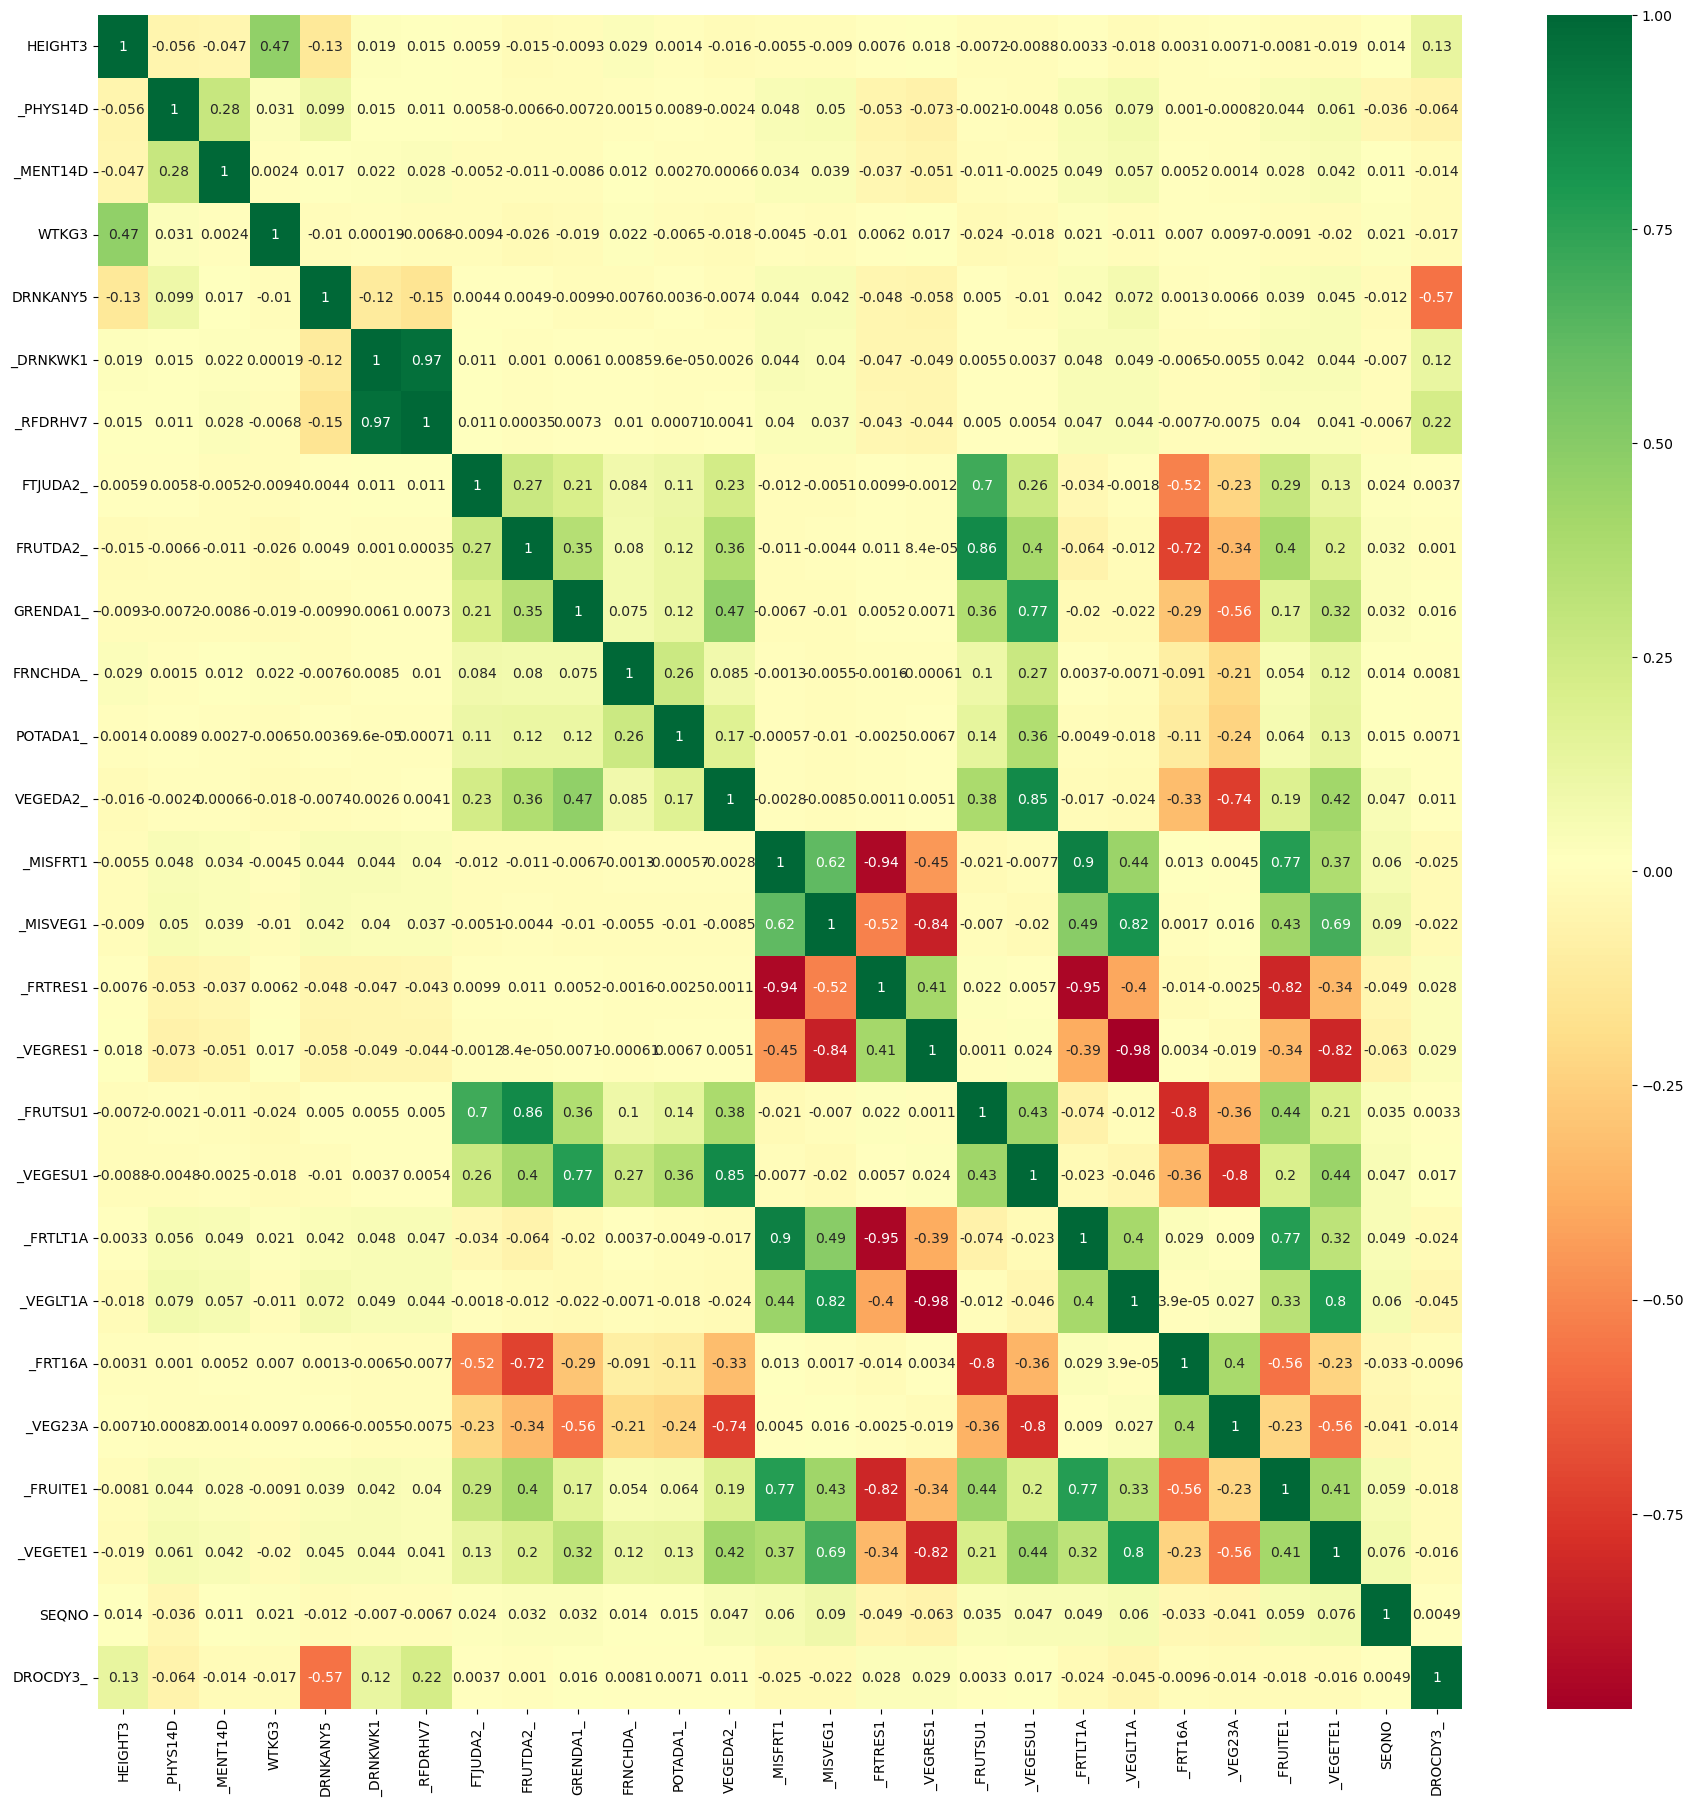

In [88]:
#Chesk for correlation between the numeric vairbales 
plt.figure(figsize=(12,8))
plt.figure(figsize=(22,22))
sns.heatmap(processed_features_df[num_cols].corr(),cmap='RdYlGn',annot=True)

In [ ]:
#We can see the presence of significant multicolinearity between the fruits and vegetable columns as well 